In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.autograd import Variable

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

from matplotlib import gridspec
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(3)

In [2]:
# agrmax(target) = 2
def target(x):
    return torch.exp(-(x - 2)**2) + torch.exp(-(x - 6)**2/10) + 1/ (x**2 + 1) 

# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(-5, 15, 6))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)-- no noise here
train_y = Variable(target(train_x))

#true target (unknown)
x = Variable(torch.linspace(-5, 15, 1000))
y = Variable(target(x))

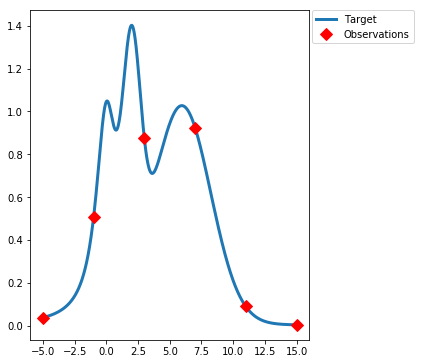

In [3]:
# plotting gp 
def plot_gp(train_x, train_y, x, y, rand_var=None, model=False, acq = None, bo=False):
    fig = plt.figure(figsize=(5,10))
    gs = gridspec.GridSpec(2,1,height_ratios=[2, 1]) 
    axis = plt.subplot(gs[0])
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(train_x, train_y, 'D', markersize=8, label=u'Observations', color='r')
    
    # if model is trained 
    if model == True:
        lower, upper = rand_var.confidence_region()
        mean = rand_var.mean().data.numpy()
        var = rand_var.var().data.numpy()
        axis.plot(x, mean, '--', color='k', label='Prediction')
       # axis.fill_between(x, lower.data.numpy(), upper.data.numpy(), alpha=.6, label='95% confidence interval')
        axis.fill_between(x, y - 1.96 * var , y + 1.96 * var, alpha=.3, label='95% confidence interval')
    
    # if acqusition function is available
    if bo == True:
        acqusition = plt.subplot(gs[1])
        acqusition.plot(x, acq.data.numpy(), label='Utility Function', color='purple')
        acqusition.plot(x[torch.argmax(acq)], torch.max(acq).data.numpy(), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
        acqusition.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
# target function and observations 
plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy())

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-5,15]
        self.mean_module = ConstantMean(constant_bounds=(-5,15))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [5]:
# train model to get the hypeparameters 
def train_model(model,train_x,train_y):   
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 20
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
            i + 1, training_iter, loss.data[0],
            model.covar_module.log_lengthscale.data[0, 0],
            model.likelihood.log_noise.data[0]
        ))
        optimizer.step()


In [6]:
# predict
def eval_model(model,likelihood):   
    # Put model and likelihood into eval mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with gpytorch.fast_pred_var():
        observed_pred = likelihood(model(x))
    return observed_pred

In [7]:
#acqusition function using upper confidence bound 
def ucb(observed_pred, kappa=5):
    mean = observed_pred.mean()
    var = observed_pred.var()
    acq = mean + kappa * torch.sqrt(var)
    return acq,torch.argmax(acq)

Iter 1/20 - Loss: 1.385   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/20 - Loss: 1.353   log_lengthscale: 0.099   log_noise: -0.100
Iter 3/20 - Loss: 1.327   log_lengthscale: 0.178   log_noise: -0.200
Iter 4/20 - Loss: 1.309   log_lengthscale: 0.259   log_noise: -0.300
Iter 5/20 - Loss: 1.296   log_lengthscale: 0.346   log_noise: -0.399
Iter 6/20 - Loss: 1.290   log_lengthscale: 0.407   log_noise: -0.499
Iter 7/20 - Loss: 1.286   log_lengthscale: 0.481   log_noise: -0.597
Iter 8/20 - Loss: 1.291   log_lengthscale: 0.548   log_noise: -0.695
Iter 9/20 - Loss: 1.295   log_lengthscale: 0.624   log_noise: -0.791
Iter 10/20 - Loss: 1.284   log_lengthscale: 0.706   log_noise: -0.887
Iter 11/20 - Loss: 1.253   log_lengthscale: 0.790   log_noise: -0.981
Iter 12/20 - Loss: 1.241   log_lengthscale: 0.879   log_noise: -1.074
Iter 13/20 - Loss: 1.197   log_lengthscale: 0.968   log_noise: -1.166
Iter 14/20 - Loss: 1.147   log_lengthscale: 1.057   log_noise: -1.256
Iter 15/20 - Loss: 1.094   log

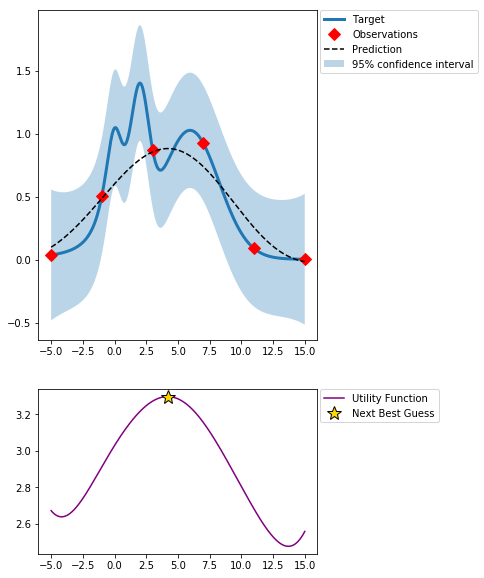

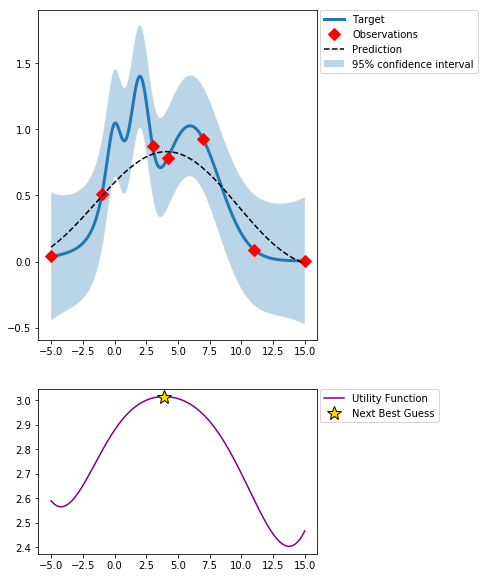

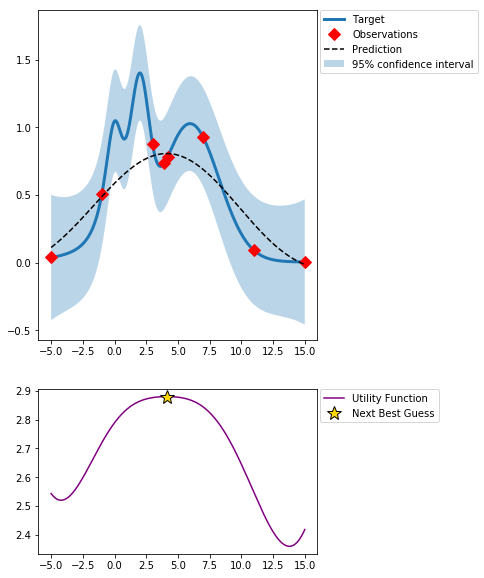

In [8]:
for i in range(3):
    # initialize likelihood and model
    likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
    model = ExactGPModel(train_x.data, train_y.data, likelihood)

    #train model
    train_model(model,train_x,train_y)
    observed_pred = eval_model(model,likelihood)
    
    acq,index = ucb(observed_pred)
    xx = Variable(x[index]).view(1)
    yy = target(xx)
    plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy(), observed_pred, True, acq, True)

    # append the next best guess into training set 
    train_x = torch.cat((train_x,xx))
    train_y = torch.cat((train_y,yy))


In [9]:
torch.cuda.current_device()

3